<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 2195, '日付': '2021-08-02T08:00:00.000Z'},
 {'小計': 3709, '日付': '2021-08-03T08:00:00.000Z'},
 {'小計': 4166, '日付': '2021-08-04T08:00:00.000Z'},
 {'小計': 5042, '日付': '2021-08-05T08:00:00.000Z'},
 {'小計': 4515, '日付': '2021-08-06T08:00:00.000Z'},
 {'小計': 4566, '日付': '2021-08-07T08:00:00.000Z'},
 {'小計': 4066, '日付': '2021-08-08T08:00:00.000Z'},
 {'小計': 2884, '日付': '2021-08-09T08:00:00.000Z'},
 {'小計': 2612, '日付': '2021-08-10T08:00:00.000Z'},
 {'小計': 4200, '日付': '2021-08-11T08:00:00.000Z'},
 {'小計': 4989, '日付': '2021-08-12T08:00:00.000Z'},
 {'小計': 5773, '日付': '2021-08-13T08:00:00.000Z'},
 {'小計': 5094, '日付': '2021-08-14T08:00:00.000Z'},
 {'小計': 4295, '日付': '2021-08-15T08:00:00.000Z'},
 {'小計': 2962, '日付': '2021-08-16T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-08-12 17:00:00+09:00,1865,0,4989,2021-08-12 17:00:00+09:00
2021-08-13 17:00:00+09:00,1747,0,5773,2021-08-13 17:00:00+09:00
2021-08-14 17:00:00+09:00,2061,0,5094,2021-08-14 17:00:00+09:00
2021-08-15 17:00:00+09:00,1716,0,4295,2021-08-15 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-08-12 17:00:00+09:00,1865,0,4989,2021-08-12 17:00:00+09:00,1852.000000,12964.0,0.0,0.0,3976.000000,27832.0
2021-08-13 17:00:00+09:00,1747,0,5773,2021-08-13 17:00:00+09:00,1878.714286,13151.0,0.0,0.0,4155.714286,29090.0
2021-08-14 17:00:00+09:00,2061,0,5094,2021-08-14 17:00:00+09:00,1882.000000,13174.0,0.0,0.0,4231.142857,29618.0
2021-08-15 17:00:00+09:00,1716,0,4295,2021-08-15 17:00:00+09:00,1842.714286,12899.0,0.0,0.0,4263.857143,29847.0
2021-08-16 17:00:00+09:00,0,0,2962,2021-08-16 17:00:00+09:00,1574.428571,11021.0,0.0,0.0,4275.000000,29925.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-08-02 17:00:00+09:00,1594,0,2195,2021-08-02 17:00:00+09:00,1365.571429,9559.0,0.0,0.0,3214.428571,22501.0,'21w31,Mon
2021-08-03 17:00:00+09:00,1384,0,3709,2021-08-03 17:00:00+09:00,1417.571429,9923.0,0.0,0.0,3337.428571,23362.0,'21w31,Tue
2021-08-04 17:00:00+09:00,1541,0,4166,2021-08-04 17:00:00+09:00,1461.285714,10229.0,0.0,0.0,3478.714286,24351.0,'21w31,Wed
2021-08-05 17:00:00+09:00,1528,0,5042,2021-08-05 17:00:00+09:00,1495.714286,10470.0,0.0,0.0,3646.857143,25528.0,'21w31,Thu
2021-08-06 17:00:00+09:00,1560,0,4515,2021-08-06 17:00:00+09:00,1537.714286,10764.0,0.0,0.0,3820.428571,26743.0,'21w31,Fri
2021-08-07 17:00:00+09:00,2038,0,4566,2021-08-07 17:00:00+09:00,1596.142857,11173.0,0.0,0.0,3893.000000,27251.0,'21w31,Sat
2021-08-08 17:00:00+09:00,1991,0,4066,2021-08-08 17:00:00+09:00,1662.285714,11636.0,0.0,0.0,4037.000000,28259.0,'21w31,Sun
2021-08-09 17:00:00+09:00,1878,0,2884,2021-08-09 17:00:00+09:00,1702.857143,11920.0,0.0,0.0,4135.428571,28948.0,'21w32,Mon
2021-08-10 17:00:00+09:00,1950,0,2612,2021-08-10 17:00:00+09:00,1783.714286,12486.0,0.0,0.0,3978.714286,27851.0,'21w32,Tue
2021-08-11 17:00:00+09:00,1682,0,4200,2021-08-11 17:00:00+09:00,1803.857143,12627.0,0.0,0.0,3983.571429,27885.0,'21w32,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-08-01 17:00:00+09:00,3105.000000,21735
2021-08-08 17:00:00+09:00,4037.000000,28259
2021-08-15 17:00:00+09:00,4263.857143,29847
2021-08-16 17:00:00+09:00,2962.000000,2962
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-08-02 17:00:00+09:00,1594,0,2195,2021-08-02 17:00:00+09:00,1365.571429,9559.0,0.0,0.0,3214.428571,22501.0,'21w31,Mon,NaN,NaN
2021-08-03 17:00:00+09:00,1384,0,3709,2021-08-03 17:00:00+09:00,1417.571429,9923.0,0.0,0.0,3337.428571,23362.0,'21w31,Tue,NaN,NaN
2021-08-04 17:00:00+09:00,1541,0,4166,2021-08-04 17:00:00+09:00,1461.285714,10229.0,0.0,0.0,3478.714286,24351.0,'21w31,Wed,NaN,NaN
2021-08-05 17:00:00+09:00,1528,0,5042,2021-08-05 17:00:00+09:00,1495.714286,10470.0,0.0,0.0,3646.857143,25528.0,'21w31,Thu,NaN,NaN
2021-08-06 17:00:00+09:00,1560,0,4515,2021-08-06 17:00:00+09:00,1537.714286,10764.0,0.0,0.0,3820.428571,26743.0,'21w31,Fri,NaN,NaN
2021-08-07 17:00:00+09:00,2038,0,4566,2021-08-07 17:00:00+09:00,1596.142857,11173.0,0.0,0.0,3893.000000,27251.0,'21w31,Sat,NaN,NaN
2021-08-08 17:00:00+09:00,1991,0,4066,2021-08-08 17:00:00+09:00,1662.285714,11636.0,0.0,0.0,4037.000000,28259.0,'21w31,Sun,4037.000000,28259.0
2021-08-09 17:00:00+09:00,1878,0,2884,2021-08-09 17:00:00+09:00,1702.857143,11920.0,0.0,0.0,4135.428571,28948.0,'21w32,Mon,NaN,NaN
2021-08-10 17:00:00+09:00,1950,0,2612,2021-08-10 17:00:00+09:00,1783.714286,12486.0,0.0,0.0,3978.714286,27851.0,'21w32,Tue,NaN,NaN
2021-08-11 17:00:00+09:00,1682,0,4200,2021-08-11 17:00:00+09:00,1803.857143,12627.0,0.0,0.0,3983.571429,27885.0,'21w32,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

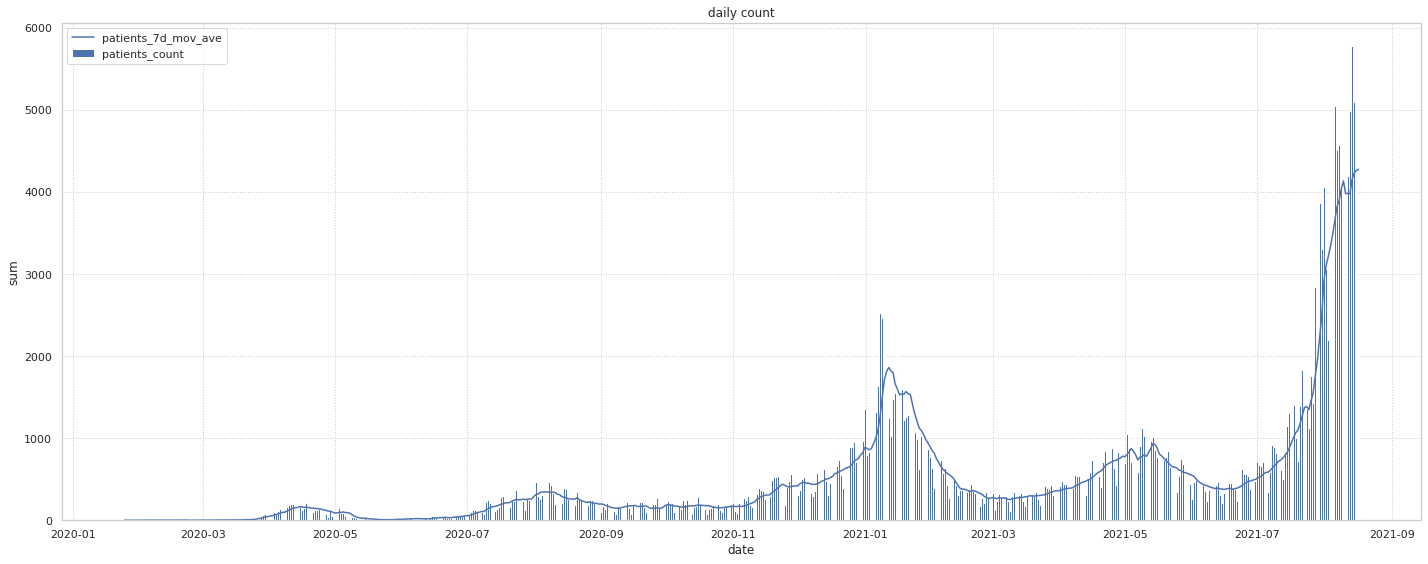

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
556,1.627891e+09,2021,8,2,0,1,0,0,0,0,0,556,0,482,1594,1365.571429,9559.0,0,0.0,0.0,2195,3214.428571,22501.0
557,1.627978e+09,2021,8,3,0,0,0,0,0,1,0,557,0,483,1384,1417.571429,9923.0,0,0.0,0.0,3709,3337.428571,23362.0
558,1.628064e+09,2021,8,4,0,0,0,0,0,0,1,558,0,484,1541,1461.285714,10229.0,0,0.0,0.0,4166,3478.714286,24351.0
559,1.628150e+09,2021,8,5,0,0,0,0,1,0,0,559,0,485,1528,1495.714286,10470.0,0,0.0,0.0,5042,3646.857143,25528.0
560,1.628237e+09,2021,8,6,1,0,0,0,0,0,0,560,0,486,1560,1537.714286,10764.0,0,0.0,0.0,4515,3820.428571,26743.0
561,1.628323e+09,2021,8,7,0,0,1,0,0,0,0,561,0,487,2038,1596.142857,11173.0,0,0.0,0.0,4566,3893.000000,27251.0
562,1.628410e+09,2021,8,8,0,0,0,1,0,0,0,562,0,488,1991,1662.285714,11636.0,0,0.0,0.0,4066,4037.000000,28259.0
563,1.628496e+09,2021,8,9,0,1,0,0,0,0,0,563,0,489,1878,1702.857143,11920.0,0,0.0,0.0,2884,4135.428571,28948.0
564,1.628582e+09,2021,8,10,0,0,0,0,0,1,0,564,0,490,1950,1783.714286,12486.0,0,0.0,0.0,2612,3978.714286,27851.0
565,1.628669e+09,2021,8,11,0,0,0,0,0,0,1,565,0,491,1682,1803.857143,12627.0,0,0.0,0.0,4200,3983.571429,27885.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            571 non-null    float64
 1   year                 571 non-null    int64  
 2   month                571 non-null    int64  
 3   day                  571 non-null    int64  
 4   Fri                  571 non-null    uint8  
 5   Mon                  571 non-null    uint8  
 6   Sat                  571 non-null    uint8  
 7   Sun                  571 non-null    uint8  
 8   Thu                  571 non-null    uint8  
 9   Tue                  571 non-null    uint8  
 10  Wed                  571 non-null    uint8  
 11  passed               571 non-null    int64  
 12  emergency            571 non-null    int64  
 13  em_passed            571 non-null    int64  
 14  contacts_count       571 non-null    int64  
 15  contacts_7d_mov_ave  571 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.710000e+02,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.00000,571.000000,571.000000,571.000000
mean,1.604477e+09,2020.399299,5.851138,15.669002,0.143608,0.143608,0.143608,0.143608,0.141856,0.141856,0.141856,285.000000,0.085814,215.859895,684.026270,677.152823,4740.063047,645.392294,645.392294,4517.74606,494.035026,471.242007,3298.665499
std,1.425408e+07,0.490184,3.138987,8.841334,0.350999,0.350999,0.350999,0.350999,0.349209,0.349209,0.349209,164.977776,0.280335,157.790160,456.021396,437.839167,3064.884516,849.917292,769.704281,5387.92997,787.348561,702.976681,4920.855915
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.592165e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,142.500000,0.000000,68.500000,379.500000,382.571429,2678.000000,0.000000,0.000000,0.00000,87.500000,101.714286,712.000000
50%,1.604477e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,285.000000,0.000000,211.000000,529.000000,549.285714,3845.000000,0.000000,0.000000,0.00000,260.000000,269.285714,1885.000000
75%,1.616789e+09,2021.000000,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427.500000,0.000000,353.500000,794.500000,777.642857,5443.500000,1293.000000,1260.857143,8826.00000,555.500000,551.214286,3858.500000
max,1.629101e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,570.000000,1.000000,496.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.00000,5773.000000,4275.000000,29925.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.848281,0.139555,-0.016132,-0.003726,0.003726,-0.001242,0.001242,0.002467,-0.002467,1.312989e-18,1.000000e+00,-0.347584,0.996802,-0.143843,-0.148754,-0.148750,-0.580070,-0.625246,-0.625246,0.575914,0.601207,0.601215
year,8.482809e-01,1.000000,-0.403695,-0.047173,0.002625,0.002625,0.002625,0.002625,-0.003518,-0.003518,-3.518042e-03,8.482809e-01,-0.249795,0.861788,-0.175953,-0.172946,-0.172944,-0.619652,-0.684228,-0.684228,0.496125,0.530577,0.530580
month,1.395546e-01,-0.403695,1.000000,-0.031869,-0.012409,0.001921,-0.007633,-0.002856,0.011296,0.003293,6.494422e-03,1.395546e-01,-0.130997,0.108625,0.085864,0.071922,0.071925,0.158756,0.202886,0.202886,0.068702,0.049123,0.049132
day,-1.613152e-02,-0.047173,-0.031869,1.000000,0.011387,-0.003877,0.005733,0.000646,-0.004653,-0.010336,1.028979e-03,-1.613152e-02,0.000863,-0.015528,-0.037746,-0.040839,-0.040843,0.014119,0.001647,0.001647,-0.040464,-0.056723,-0.056729
Fri,-3.726481e-03,0.002625,-0.012409,0.011387,1.000000,-0.167689,-0.167689,-0.167689,-0.166493,-0.166493,-1.664934e-01,-3.726481e-03,-0.000656,-0.002930,-0.015752,-0.003072,-0.003071,0.030462,-0.001796,-0.001796,0.033158,-0.000756,-0.000759
Mon,3.726481e-03,0.002625,0.001921,-0.003877,-0.167689,1.000000,-0.167689,-0.167689,-0.166493,-0.166493,-1.664934e-01,3.726481e-03,-0.000656,0.003817,0.023257,0.003088,0.003088,0.125250,-0.001796,-0.001796,-0.086856,0.011785,0.011786
Sat,-1.242160e-03,0.002625,-0.007633,0.005733,-0.167689,-0.167689,1.000000,-0.167689,-0.166493,-0.166493,-1.664934e-01,-1.242160e-03,-0.000656,-0.000681,0.052927,0.000289,0.000290,-0.148082,-0.001796,-0.001796,0.040134,0.004418,0.004415
Sun,1.242160e-03,0.002625,-0.002856,0.000646,-0.167689,-0.167689,-0.167689,1.000000,-0.166493,-0.166493,-1.664934e-01,1.242160e-03,-0.000656,0.001568,-0.016618,0.003088,0.003088,-0.136561,-0.001796,-0.001796,-0.019006,0.008778,0.008777
Thu,2.466605e-03,-0.003518,0.011296,-0.004653,-0.166493,-0.166493,-0.166493,-0.166493,1.000000,-0.165306,-1.653061e-01,2.466605e-03,0.000879,0.001667,-0.003163,0.001818,0.001819,0.039387,0.002407,0.002407,0.055437,-0.003292,-0.003289
Tue,-2.466605e-03,-0.003518,0.003293,-0.010336,-0.166493,-0.166493,-0.166493,-0.166493,-0.165306,1.000000,-1.653061e-01,-2.466605e-03,0.000879,-0.002854,-0.027125,-0.003996,-0.003995,0.053059,0.002407,0.002407,-0.034391,-0.012672,-0.012671


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,1.628755e+09,0,0,0,0,1,0,0,566,0,492,1865,0,4989,3976.000000,27832.0
567,1.628842e+09,1,0,0,0,0,0,0,567,0,493,1747,0,5773,4155.714286,29090.0
568,1.628928e+09,0,0,1,0,0,0,0,568,0,494,2061,0,5094,4231.142857,29618.0
569,1.629014e+09,0,0,0,1,0,0,0,569,0,495,1716,0,4295,4263.857143,29847.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
566,1.628755e+09,566,0,4989,3976.000000,27832.0
567,1.628842e+09,567,0,5773,4155.714286,29090.0
568,1.628928e+09,568,0,5094,4231.142857,29618.0
569,1.629014e+09,569,0,4295,4263.857143,29847.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

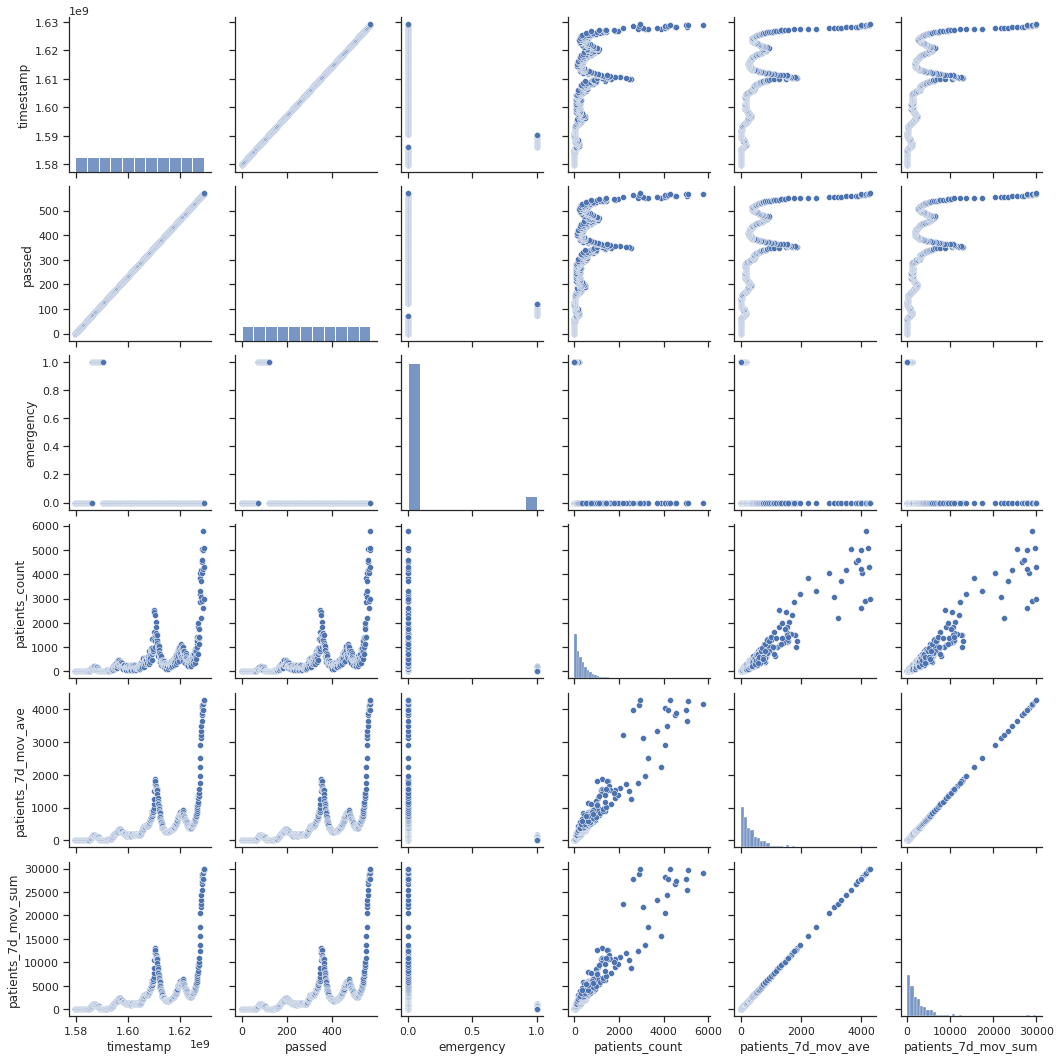

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.11
